# Notebook to check MELD_BIDS folder


In [1]:
import os
import glob
import pandas as pd
import numpy as np
import json
import shutil

In [2]:
# initialise 

site_code = 'H28'
site_folder = f'/home/mathilde/Documents/RDS/MELD_FE/DATA/MELD_{site_code}'

BIDS_path= os.path.join(site_folder, 'MELD_BIDS')


### 1. Check modalities available in MELD_BIDS

In [3]:
def harmonise_meld_name(name):
    split = name.split('_')  
    # exclude specific characters
    harmo_name= ''.join(split)
    
    return harmo_name


In [4]:
# get the subjects from the demographic file or from MELD BIDS

#from the demographic file
demographic_file = os.path.join(site_folder,f'MELD_participants_infos_{site_code}.csv')
subjects = pd.read_csv(demographic_file)['id']  

#from MELD_BIDS folder
# subjects = glob.glob(os.path.join(BIDS_path, '*'))


print(f'number of subjects: {len(subjects)}') 

number of subjects: 10


In [5]:
# check the available modality and associated json files for each subject

df=pd.DataFrame()

values={}
for subject in subjects :
    subject_bids = 'sub-'+harmonise_meld_name(subject)
    values['ID']=subject
    for mod in ['preop_T1w', 'postop_T1w','preop_T2w','preop_FLAIR','preop_DWI', 'lesion_MASK']:
        niis =  glob.glob(os.path.join(BIDS_path, subject_bids, f'*/*{mod}*.nii*'))
        jsons =  glob.glob(os.path.join(BIDS_path, subject_bids, f'*/*{mod}*.json'))
        
        values[f'{mod}_nii'] = len(niis)
        values[f'{mod}_json'] = len(jsons)

    df=pd.concat([df,pd.DataFrame([values])])


In [6]:
# overview of the MRI data available
df.sum()

ID                  MELD_H28_P_0001MELD_H28_P_0002MELD_H28_P_0003M...
preop_T1w_nii                                                      10
preop_T1w_json                                                     10
postop_T1w_nii                                                      8
postop_T1w_json                                                     9
preop_T2w_nii                                                       4
preop_T2w_json                                                      4
preop_FLAIR_nii                                                     7
preop_FLAIR_json                                                    7
preop_DWI_nii                                                       0
preop_DWI_json                                                      0
lesion_MASK_nii                                                     0
lesion_MASK_json                                                    0
dtype: object

In [7]:
# indicate who does not have a preop t1
df[(df.preop_DWI_nii<1) & (df.preop_DWI_json>0)]

,ID,preop_T1w_nii,preop_T1w_json,postop_T1w_nii,postop_T1w_json,preop_T2w_nii,preop_T2w_json,preop_FLAIR_nii,preop_FLAIR_json,preop_DWI_nii,preop_DWI_json,lesion_MASK_nii,lesion_MASK_json


In [8]:
# add sum columns and rows
df.loc['Column_Total'] = df.sum(numeric_only=True, axis=0)
df.loc[:,'Row_Total'] = df.sum(numeric_only=True, axis=1)

In [9]:
#save summary 
file = os.path.join(site_folder,'summary_MRI_MELDBIDS.csv')
df.to_csv(file)

## 2. Plot MRI volumes

In [10]:
import nibabel as nib
import matplotlib.pyplot as plt

In [14]:
def plot_mosaic_MRI_view(img_data, view=0, n_slices=20, edge_slices=20,file=None):
    #define the slices
    shape = img_data.shape
    slices =np.linspace(edge_slices, shape[view]-edge_slices, n_slices).astype(int)
    print(slices)

    # Define the number of rows and columns for the panel
    num_cols = 3
    num_rows = int(np.ceil(n_slices/num_cols))
    
    # Create a figure and a set of subplots
    plt.style.use("dark_background")
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(2*num_cols, 2*num_rows))
    axes=axes.flatten()
    # Loop through the slices and plot them
    for i, slice_idx in enumerate(slices):
        # Plot the MRI slice
        if view==0:
            axes[i].imshow(img_data[slice_idx,:, :], cmap='gray')
            axes[i].set_title(f'x={slice_idx}', color='red',  pad=-14, fontsize=8)
        elif view==1:
            axes[i].imshow(img_data[:, slice_idx, : ], cmap='gray')
            axes[i].set_title(f'y={slice_idx}', color='red',  pad=-14, fontsize=8)
        elif view==2:
            axes[i].imshow(img_data[:, :, slice_idx], cmap='gray')
            axes[i].set_title(f'z={slice_idx}', color='red', pad=-14,  fontsize=8)
        else:
            return
        
        axes[i].axis('off')
        axes[i].patch.set_facecolor('black')

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0, hspace=0)
  

    # Show the panel of MRI slices
    plt.show()

    if file!=None:
        fig.savefig(file)


In [15]:
# text base for HTML

text_initial = f"<html>\n \
            <table>\n"

text_base = "<tr>\n \
            <td colspan=4><center>{}</center><br></td>\n \
            </tr>\n \
            <tr>\n \
            <td><a href='file:{}'><img src='{}'></a></td>\n \
            <td><a href='file:{}'><img src='{}'></a></td>\n \
            <td><a href='file:{}'><img src='{}'></a></td>\n \
            </tr>\n \
            "

[ 30  47  65  83 101 119 136 154 172 190 208 226]


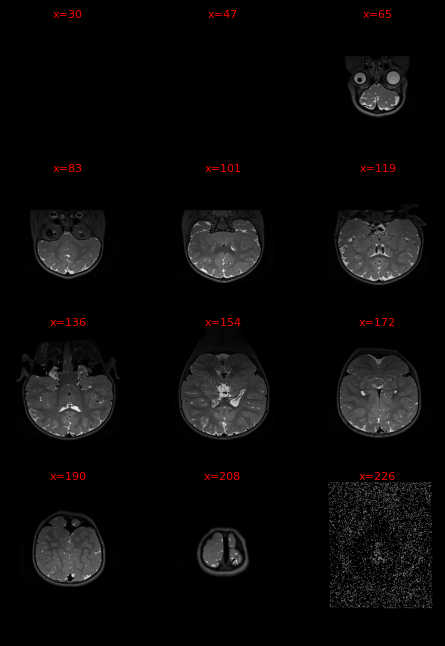

In [21]:
# create folder
folder_qc=os.path.join(site_folder, 'qc_images')
os.makedirs(folder_qc, exist_ok=True)

modality = 'preop_T2w'

# initialise html
html_file = os.path.join(folder_qc, f'summary_views_{modality}.html')

# define the number of slices to visualise
n_slices=12
# define the view 
view = 2
#define the number of slices on the edge that you want to crop
edge_slices=30

text_subjects=""
for subject in subjects:
    id_bids = 'sub-'+harmonise_meld_name(subject)

    file = os.path.join(BIDS_path, id_bids, 'anat', f'{id_bids}_3T_{modality}.nii.gz')

    if os.path.isfile(file):
        #load file
        img = nib.load(file).get_fdata()
        #create mosaic MRI
        file_saves = []
        for view in [0,1,2]:
            file_save = os.path.join(folder_qc,f"{os.path.basename(file).split('.nii')[0]}_view{view}.png")
            file_saves.append(file_save)
            plot_mosaic_MRI_view(img, view=view, n_slices=n_slices, edge_slices=edge_slices,file=file_save)
        title = os.path.basename(file).split('.nii')[0]
        text_subjects = text_subjects + text_base.format(title, file_saves[0],file_saves[0], file_saves[1], file_saves[1], file_saves[2], file_saves[2])
            
# add images per subjects
with open(html_file,'w') as f:
    f.write(text_initial)
    f.write(text_subjects)



In [160]:
text_subjects

"<tr>\n             <td colspan=4><center>sub-MELDH10C0001_3T_preop_T1w</center><br></td>\n             </tr>\n             <tr>\n             <td><a href='file:/'><img src='/'></a></td>\n             <td><a href='file:h'><img src='h'></a></td>\n             <td><a href='file:o'><img src='o'></a></td>\n             </tr>\n             <tr>\n             <td colspan=4><center>sub-MELDH10C0001_3T_preop_T1w</center><br></td>\n             </tr>\n             <tr>\n             <td><a href='file:/'><img src='/'></a></td>\n             <td><a href='file:h'><img src='h'></a></td>\n             <td><a href='file:o'><img src='o'></a></td>\n             </tr>\n             <tr>\n             <td colspan=4><center>sub-MELDH10C0001_3T_preop_T1w</center><br></td>\n             </tr>\n             <tr>\n             <td><a href='file:/'><img src='/'></a></td>\n             <td><a href='file:h'><img src='h'></a></td>\n             <td><a href='file:o'><img src='o'></a></td>\n             </tr>\n    

In [155]:
np.hstack(text_subjects)

array(["<tr>\n             <td colspan=4><center>sub-MELDH10C0001_3T_preop_T1w</center><br></td>\n             </tr>\n             <tr>\n             <td><a href='file:/'><img src='/'></a></td>\n             <td><a href='file:h'><img src='h'></a></td>\n             <td><a href='file:o'><img src='o'></a></td>\n             </tr>\n             ",
       "<tr>\n             <td colspan=4><center>sub-MELDH10C0001_3T_preop_T1w</center><br></td>\n             </tr>\n             <tr>\n             <td><a href='file:/'><img src='/'></a></td>\n             <td><a href='file:h'><img src='h'></a></td>\n             <td><a href='file:o'><img src='o'></a></td>\n             </tr>\n             ",
       "<tr>\n             <td colspan=4><center>sub-MELDH10C0001_3T_preop_T1w</center><br></td>\n             </tr>\n             <tr>\n             <td><a href='file:/'><img src='/'></a></td>\n             <td><a href='file:h'><img src='h'></a></td>\n             <td><a href='file:o'><img src='o'></a></